In [18]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [19]:
## Camera Constants
# Source coords for perspective xform
src_coords = np.float32([[240, 719],
                              [579, 450],
                              [712, 450],
                              [1165, 719]])

# Dest coords for perspective xform
dst_coords = np.float32([[300, 719],
                              [300, 0],
                              [900, 0],
                              [900, 719]])
# Perspective Transform matrix
M = cv2.getPerspectiveTransform(src_coords, dst_coords)

# Inverse Perspective Transform matrix
Minv = cv2.getPerspectiveTransform(dst_coords, src_coords)

In [20]:
# Step 1: Calibrate Camera
def calibrate_camera(nx, ny, files):
    images = glob.glob(files)

    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane

    # Prepare objpoints like (0,0,0), (1,0,0), ... (7,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Read in images and find chessboard corners
    for fname in images:
        # Read in 
        img = mpimg.imread(fname)
        # Convert image to gray
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            # draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    # Get camera calibration params
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
        objpoints, 
        imgpoints, 
        gray.shape[::-1],
        None, 
        None
    )
    return mtx, dist

In [21]:
# Step 2: Apply distortion correction to the image
def undistort_image(original_img, mtx, dist):
    # Apply distortion correction to the image
    return cv2.undistort(original_img, mtx, dist, None, mtx)

In [22]:
# Step 3: Get the binary image using thresholding etc
def threshold_binary(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]

    # Grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)  # Take the derivative in x
    abs_sobelx = np.absolute(sobelx)  # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 30
    thresh_max = 150
    sxbinary = np.zeros_like(scaled_sobel)
    # sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    retval, sxthresh = cv2.threshold(scaled_sobel, 30, 150, cv2.THRESH_BINARY)
    sxbinary[(sxthresh >= thresh_min) & (sxthresh <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 175
    s_thresh_max = 250
    s_binary = np.zeros_like(s_channel)
    # Use inRange instead of multiple thresholds
    s_thresh = cv2.inRange(s_channel.astype('uint8'), s_thresh_min, s_thresh_max)

    s_binary[(s_thresh == 255)] = 1

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary


In [23]:
# Step 4: Apply perspective transform
def perspective_transform(binary_img, perspective_transformed_matrix):
    img_size = (binary_img.shape[1], binary_img.shape[0])
    return cv2.warpPerspective(binary_img, perspective_transformed_matrix, img_size, flags=cv2.INTER_LINEAR)

In [24]:
## Lane Constants
frame_number = 0
# Lane locations from previous frame
last_left_x = 0
last_right_x = 0
# Lane locations from current frame
left_x = 0
right_x = 0
# Lane persp image
left_lane_img = 0
right_lane_img = 0
# Lane persp debug image
lane_debug_img = 0
# Frames since lane last detected
# Init with large value to trigger full scan
left_last_seen = 999
right_last_seen = 999
# Lane fit coords
left_fitx = 0
left_fity = 0
right_fitx = 0
right_fity = 0
# Lane radius of curvature
left_curverad = 0
right_curverad = 0
# Lanes found in last frame?
left_lane_found = False
right_lane_found = False
# Lane polynomial fits
left_fit = []
right_fit = []

In [25]:
# Step 5: Locate Lanes
def locate_lanes(img):
    global frame_number
    global last_left_x
    global last_right_x
    global left_x
    global right_x
    global left_lane_img
    global right_lane_img
    global lane_debug_img
    # Frames since lane last detected
    # Init with large value to trigger full scan
    global left_last_seen
    global right_last_seen

    # Is this the first frame of video?
    if frame_number == 0 or left_last_seen > 5 or right_last_seen > 5:
        # Generate histogram over bottom half of image
        histogram = np.sum(img[int(img.shape[0] / 2):, :], axis=0)
        # Find X coords of two peaks of histogram
        est_left_x, est_right_x = _full_scan(histogram)
    else:
        est_left_x = last_left_x
        est_right_x = last_right_x

    fallback_left_x = est_left_x
    fallback_right_x = est_right_x
    left_trend = 0
    right_trend = 0

    # Run a sliding window up the image to detect pixels
    left_lane_img = np.zeros(img.shape[0:2], np.float32)
    right_lane_img = np.zeros(img.shape[0:2], np.float32)
    temp_img = img * 255
    lane_debug_img = np.dstack((temp_img, temp_img, temp_img))

    found_last_left = False
    found_last_right = False
    left_window = 40
    right_window = 40
    left_conc_sections = 0
    right_conc_sections = 0
    for i in range(10, 0, -1):
        start_y = int(i * img.shape[0] / 10)
        end_y = int((i - 1) * img.shape[0] / 10)
        img_sect = img[end_y:start_y, :]
        histogram = np.sum(img_sect, axis=0)
        left_x, right_x, found_last_left, found_last_right, new_left_trend, new_right_trend = _get_two_peak_x_coords(
            histogram, est_left_x, est_right_x, start_y, end_y, found_last_left, found_last_right, left_trend,
            right_trend)
        left_trend = int((new_left_trend + left_trend) / 2)
        right_trend = int((new_right_trend + right_trend) / 2)
        # Store the left/right x values for bottom of image
        if i == 10:
            # Set the new last values
            left_x = left_x
            right_x = right_x

        if not found_last_left:
            left_x = fallback_left_x
            left_conc_sections = 0
        elif left_conc_sections > 1:
            fallback_left_x = left_x
        if not found_last_right:
            right_x = fallback_right_x
            right_conc_sections = 0
        elif right_conc_sections > 1:
            fallback_right_x = right_x

        if found_last_left:
            left_conc_sections += 1
        if found_last_right:
            right_conc_sections += 1

        # Fill in the left lane image
        left_mask = np.zeros_like(img_sect)
        left_mask[:, left_x - left_window:left_x + left_window] = 1
        mask = (left_mask == 1)
        left_lane_img[end_y:start_y, :] = img_sect & mask

        # Fill in the right lane image
        right_mask = np.zeros_like(img_sect)
        right_mask[:, right_x - right_window:right_x + right_window] = 1
        mask = (right_mask == 1)
        right_lane_img[end_y:start_y, :] = img_sect & mask

        # Set the new last values
        est_left_x = left_x
        est_right_x = right_x

    frame_number += 1

In [26]:
# Step 6: Fit Lanes
def fit_lanes():
    global frame_number
    global last_left_x
    global last_right_x
    global left_lane_img
    global right_lane_img
    # Frames since lane last detected
    # Init with large value to trigger full scan
    global left_last_seen
    global right_last_seen
    # Lane fit coords
    global left_fitx
    global left_fity
    global right_fitx
    global right_fity
    # Lane radius of curvature
    global left_curverad
    global right_curverad
    # Lanes found in last frame?
    global left_lane_found
    global right_lane_found
    # Lane polynomial fits
    global left_fit
    global right_fit

    left_lane_found = False
    right_lane_found = False
    # Get new lane fit for left lane
    left_fit, left_fitx, left_fity, left_curverad = _fit_lane(left_lane_img)
    # Only use this new lane fit if it's close to the previous one (for smoothing)
    if frame_number == 1 or _check_lane(left_curverad, left_curverad, left_x, last_left_x):
        left_fit = left_fit
        left_fitx = left_fitx
        left_fity = left_fity
        left_curverad = left_curverad
        left_lane_found = True
        left_last_seen = 0
        last_left_x = left_x
    else:
        left_last_seen += 1

    # Get new lane fit for right lane
    right_fit, right_fitx, right_fity, right_curverad = _fit_lane(right_lane_img)
    # Only use this new lane fit if it's close to the previous one (for smoothing)
    if frame_number == 1 or _check_lane(right_curverad, right_curverad, right_x,
                                                 last_right_x):
        right_fit = right_fit
        right_fitx = right_fitx
        right_fity = right_fity
        right_curverad = right_curverad
        right_lane_found = True
        right_last_seen = 0
        last_right_x = right_x
    else:
        right_last_seen += 1
        

def _fit_lane(img):
    # Extract the list of x and y coords that are non-zero pixels
    xycoords = np.nonzero(img)
    x_arr = xycoords[1]
    y_arr = xycoords[0]

    # Fit a second order polynomial to each fake lane line
    fit = np.polyfit(y_arr, x_arr, deg=2)
    fitx = fit[0] * y_arr ** 2 + fit[1] * y_arr + fit[2]

    # Ensure we have points for min(0) & max(719) y
    # This will extend the lines in cases where the lanes
    # dont have pixels all the way to top/bottom of image
    fitx = np.insert(fitx, 0, fit[0] * 0 ** 2 + fit[1] * 0 + fit[2])
    fity = np.insert(y_arr, 0, 0)
    fitx = np.append(fitx, fit[0] * 719 ** 2 + fit[1] * 719 + fit[2])
    fity = np.append(fity, 719)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meteres per pixel in x dimension
    y_eval = np.max(y_arr)
    fit_cr = np.polyfit(y_arr * ym_per_pix, x_arr * xm_per_pix, 2)
    fitx_cr = fit_cr[0] * (y_arr * ym_per_pix) ** 2 + fit_cr[1] * y_arr * ym_per_pix + fit_cr[2]

    # Get radius of curvature
    curverad = ((1 + (2 * fit_cr[0] * y_eval + fit_cr[1]) ** 2) ** 1.5) \
               / np.absolute(2 * fit_cr[0])

    return fit, fitx, fity, curverad



def _check_lane(new_roc, prev_roc, new_x, prev_x):
    # Check RoC against standards
    # if new_roc < 587 or new_roc > 4575:
    if new_roc < 587:
        return False

    # Check previous x coord versus current for major difference 
    delta = 15
    if new_x > prev_x + delta or new_x < prev_x - delta:
        return False

    # Check RoC against previous value
    max_roc = prev_roc * 100.0
    min_roc = prev_roc / 100.0
    if new_roc >= min_roc and new_roc <= max_roc:
        return True
    else:
        return False



def _full_scan(hist):
    num_pixels_x = len(hist)
    left_side = hist[0:int(num_pixels_x / 2)]
    left_peak_x = np.argmax(left_side)
    right_side = hist[int(num_pixels_x / 2):]
    right_peak_x = np.argmax(right_side)
    right_offset = int(num_pixels_x / 2)
    right_peak_x += right_offset
    return left_peak_x, right_peak_x


def _get_two_peak_x_coords(hist, prev_left_x=-1, prev_right_x=-1, start_y=0, end_y=0, found_last_left=False,
                           found_last_right=False, left_trend=0, right_trend=0):
    # Lanes found in last frame?
    global left_lane_found
    global right_lane_found
    # Lane polynomial fits
    global left_fit
    global right_fit

    num_pixels_x = len(hist)
    left_window = 40
    right_window = 40
    found_left = True
    found_right = True

    if not found_last_left:
        left_window = 60
    if not found_last_right:
        right_window = 60
    if start_y == 720:
        left_window = 100
        right_window = 100

    left_offset = 0
    if left_lane_found:
        new_left_peak = int(left_fit[0] * start_y ** 2 + left_fit[1] * start_y + left_fit[2])
    else:
        left_side = hist[prev_left_x + left_trend - left_window:prev_left_x + left_trend + left_window]
        new_left_peak = 0
        if len(left_side) > 0:
            new_left_peak = np.argmax(left_side)
            left_offset = prev_left_x + left_trend - left_window
        if new_left_peak == 0 or len(left_side) == 0:
            new_left_peak = prev_left_x + left_trend
            left_offset = 0
            found_left = False
    left_peak_x = new_left_peak + left_offset
    right_offset = 0
    if right_lane_found:
        new_right_peak = int(right_fit[0] * start_y ** 2 + right_fit[1] * start_y + right_fit[2])
    else:
        right_side = hist[prev_right_x + right_trend - right_window:prev_right_x + right_trend + right_window]
        new_right_peak = 0
        if len(right_side) > 0:
            new_right_peak = np.argmax(right_side)
            right_offset = prev_right_x + right_trend - right_window
        if new_right_peak == 0 or len(right_side) == 0:
            new_right_peak = prev_right_x + right_trend
            right_offset = 0
            found_right = False
    right_peak_x = new_right_peak + right_offset
    if start_y == 720:
        new_left_trend = 0
        new_right_trend = 0
    else:
        new_left_trend = left_peak_x - prev_left_x
        new_right_trend = right_peak_x - prev_right_x

    return left_peak_x, right_peak_x, found_left, found_right, new_left_trend, new_right_trend

In [27]:
# step 7: Draw Lanes
def draw_lanes(img, warped, Minv):
    global last_right_x
    global left_x
    # Lane fit coords
    global left_fitx
    global left_fity
    global right_fitx
    global right_fity
    # Lane radius of curvature
    global left_curverad
    global right_curverad
    # Lanes found in last frame?
    global left_lane_found
    global right_lane_found
    # Lane polynomial fits
    global left_fit
    global right_fit
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_fity])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Draw lane lines only if lane was detected this frame
    if left_lane_found == True:
        cv2.polylines(color_warp, np.int_([pts_left]), False, (0, 0, 255), thickness=20)
    if right_lane_found == True:
        cv2.polylines(color_warp, np.int_([pts_right]), False, (255, 0, 0), thickness=20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Write the radius of curvature for each lane 
    font = cv2.FONT_HERSHEY_SIMPLEX
    left_roc = "Roc: {0:.2f}m".format(left_curverad)
    cv2.putText(result, left_roc, (10, 650), font, 1, (255, 255, 255), 2)
    right_roc = "Roc: {0:.2f}m".format(right_curverad)
    cv2.putText(result, right_roc, (1020, 650), font, 1, (255, 255, 255), 2)

    # Write the x coords for each lane 
    left_coord = "X  : {0:.2f}".format(left_x)
    cv2.putText(result, left_coord, (10, 700), font, 1, (255, 255, 255), 2)
    right_coord = "X  : {0:.2f}".format(last_right_x)
    cv2.putText(result, right_coord, (1020, 700), font, 1, (255, 255, 255), 2)

    # Write distance from center
    perfect_center = 1280 / 2.
    lane_x = last_right_x - left_x
    center_x = (lane_x / 2.0) + left_x
    cms_per_pixel = 370.0 / lane_x  # US regulation lane width = 3.7m
    dist_from_center = (center_x - perfect_center) * cms_per_pixel
    dist_text = "Distance from Center: {0:.2f} cms".format(dist_from_center)
    cv2.putText(result, dist_text, (450, 50), font, 1, (255, 255, 255), 2)

    return result

Original image


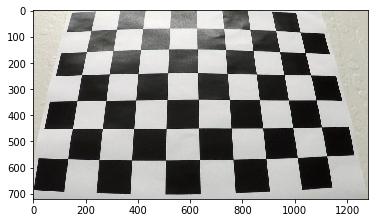

Undistored image


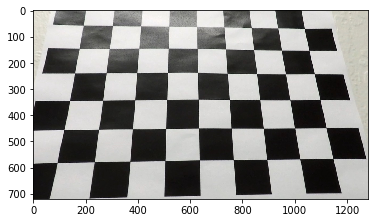

Thresholded image


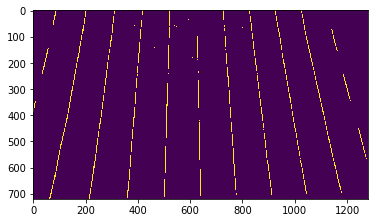

Perspective Transformed Image


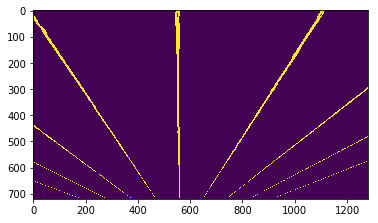

...


In [31]:

# First lets calibrate the camera
mtx, dist = calibrate_camera(nx=9, ny=6, files="camera_cal/calibration*.jpg")

# Un-distort test calibration image as demo that calibration is correct
print("Original image")
img = mpimg.imread("camera_cal/calibration3.jpg")
plt.imshow(img)
plt.show()

print("Undistored image")
undist = undistort_image(img, mtx, dist)
plt.imshow(undist)
plt.show()

print("Thresholded image")
binary_img = threshold_binary(undist)
plt.imshow(binary_img)
plt.show()

print("Perspective Transformed Image")
persp_img = perspective_transform(binary_img, M)
plt.imshow(persp_img)
plt.show()


print('...')

In [32]:
# Define the pipeline
def process_image(original_img):
    # Apply distortion correction to the image
    undist = undistort_image(original_img, mtx, dist)
    # Get the binary image using thresholding etc
    binary_img = threshold_binary(undist)
    # Apply perspective transform 
    persp_img = perspective_transform(binary_img, M)
    # Locate the lane lines
    locate_lanes(persp_img)
    # Fit polynomials and set lane x/y arrays
    fit_lanes()
    # Draw lines back onto road
    combined_img = draw_lanes(undist, persp_img, Minv)
    return combined_img

print('...')

...


In [ ]:
mtx, dist = calibrate_camera(nx=9, ny=6, files="camera_cal/calibration*.jpg")
print("Running on test images...")
#####################################
# Run our pipeline on the test images
#####################################
images = glob.glob("test_images/test*.jpg")
images.sort()

# Setup the plot grid for test images
i = 0

for fname in images:
    print("Processing image {}".format(fname))

    # Next, let's read in a test image
    img = mpimg.imread(fname)
    plt.imshow(img)
    plt.show()

    # Process the image using our pipeline
    combined_img = process_image(img)
    plt.imshow(combined_img)
    plt.show()

    i += 2


In [34]:
print("Running on test video1...")
#####################################
# Run our pipeline on the test video
#####################################
clip = VideoFileClip("./project_video.mp4")
output_video = "./project_video_processed.mp4"
output_clip = clip.fl_image(process_image)
output_clip.write_videofile(output_video, audio=False)
print('...')

Running on test video1...
[MoviePy] >>>> Building video ./project_video_processed.mp4
[MoviePy] Writing video ./project_video_processed.mp4


100%|█████████▉| 1260/1261 [02:56<00:00,  7.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_processed.mp4 

...


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))
